In [1]:
from fastai.vision import *

In [2]:
torch.cuda.empty_cache()

In [3]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [4]:
os.listdir(path)

['models', 'test', 'train', 'valid']

In [5]:
len(os.listdir(path/'train'))

1000

In [6]:
os.listdir(path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [7]:
len(os.listdir(path/'valid'))

1000

In [8]:
os.listdir(path/'valid')[:5]

['n02356798', 'n02361337', 'n02363005', 'n02364673', 'n02389026']

In [9]:
len(os.listdir(path/'test'))

100000

In [10]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00026354.JPEG',
 'ILSVRC2012_test_00000007.JPEG',
 'ILSVRC2012_test_00000008.JPEG',
 'ILSVRC2012_test_00000009.JPEG',
 'ILSVRC2012_test_00000010.JPEG']

### for creating the file structure (only valid because train was correct)

In [11]:
#os.rename(path/'val', path/'valid')
#
#train_classes = os.listdir(path/'train')
#
#for line in open('data/valid.txt'):
#    valid_path = path/'valid'/line.split(' ')[0]
#    valid_class = line.split(' ')[1].replace('\n','')
#    real_class = train_classes[int(valid_class)]
#    if not os.path.isdir(path/'valid'/real_class):
#        os.mkdir(path/'valid'/real_class)
#    os.rename(valid_path, path/'valid'/real_class/line.split(' ')[0])

In [12]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### define metric 

In [13]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### create databunch from folder structure

In [ ]:
data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=164, num_workers=8, bs=132) \
                           .normalize(imagenet_stats)

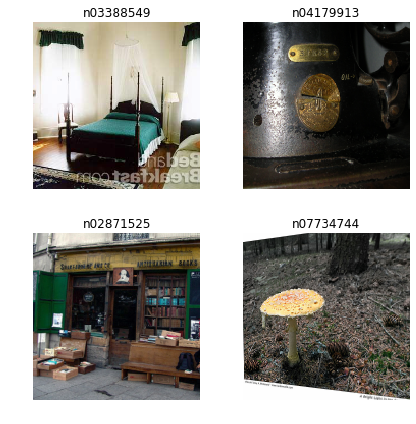

In [15]:
data_bunch.show_batch(rows=2, figsize=(6,6))

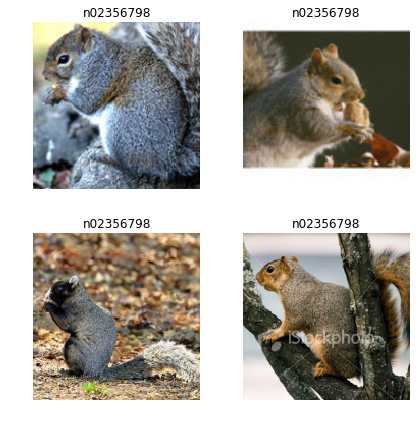

In [16]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

### create learner with resnet50 (the pytorch model is already pretrained on imagenet)

In [14]:
learn = cnn_learner(data_bunch, models.resnet50, pretrained=True, callback_fns=[ShowGraph])

In [16]:
learn.metrics=[top_5_accuracy, accuracy]

In [17]:
learn.freeze()

In [18]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


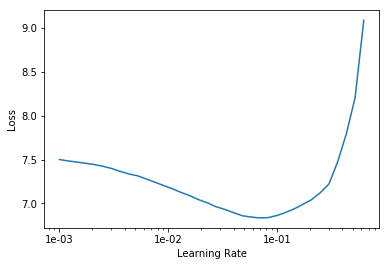

In [24]:
learn.recorder.plot(50)

In [25]:
lr = 1e-2

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.549261,1.587485,0.859640,0.635140,1:23:07
1,1.809431,1.741269,0.845540,0.617480,1:23:02
2,1.623829,1.600258,0.861000,0.635200,1:23:04
3,1.339612,1.417804,0.879360,0.675120,1:23:03
4,1.095493,1.227756,0.898640,0.708280,1:23:07
5,0.965407,1.169353,0.904940,0.719720,1:23:10


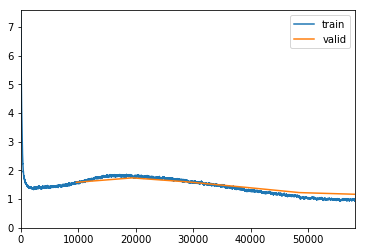

In [26]:
learn.fit_one_cycle(6, max_lr=slice(lr), div_factor=25)

In [ ]:
learn.save('164px_res50_frozen');

In [18]:
learn.load('164px_res50_frozen');

In [19]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


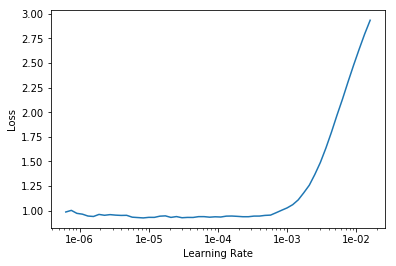

In [20]:
learn.recorder.plot()

In [20]:
lr = 3e-4

In [21]:
lrs = learn.lr_range(slice(lr/60,lr))
lrs

array([5.000000e-06, 3.872983e-05, 3.000000e-04])

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.032979,1.193163,0.904220,0.711900,1:55:44
1,1.079330,1.190444,0.902780,0.713420,1:55:25
2,0.944056,1.149293,0.908180,0.721860,1:55:23
3,0.845834,1.115926,0.912320,0.732440,1:55:16
4,0.766908,1.109353,0.913600,0.736340,1:55:17


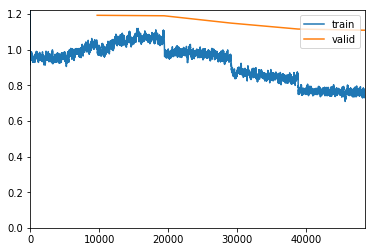

In [22]:
learn.fit_one_cycle(5, max_lr=lrs, div_factor=50)

In [23]:
learn.save('164px_res50');

### scale up image size to 255

In [14]:
data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=255, num_workers=8, bs=58) \
                           .normalize(imagenet_stats)

In [15]:
learn = cnn_learner(data_bunch, models.resnet50, pretrained=True, callback_fns=[ShowGraph])

In [16]:
learn.metrics=[top_5_accuracy, accuracy]

In [17]:
learn.freeze()

In [18]:
learn.load('164px_res50');

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


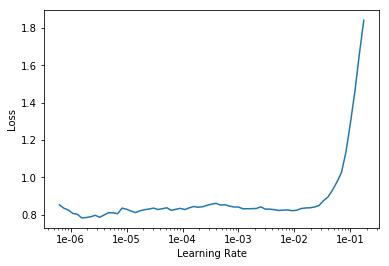

In [20]:
learn.recorder.plot()

In [21]:
lr = 1e-2

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.158917,1.298977,0.906700,0.715020,2:36:03
1,1.255340,1.331895,0.903760,0.707680,2:35:57
2,1.105724,1.224702,0.912420,0.726360,2:35:58
3,0.833184,1.085367,0.925460,0.753520,2:36:02
4,0.725418,1.013424,0.931440,0.767460,2:36:11


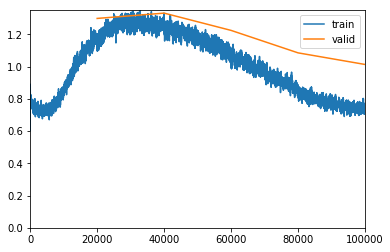

In [22]:
learn.fit_one_cycle(5, max_lr=slice(lr), div_factor=30)

In [23]:
#learn.save('255px_res50_frozen')

In [18]:
learn.load('255px_res50_frozen');

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


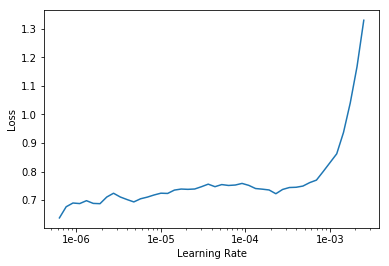

In [22]:
learn.recorder.plot()

In [23]:
lr = 2e-4

In [28]:
lrs = learn.lr_range(slice(lr/50,lr))

In [29]:
lrs

array([4.000000e-06, 2.828427e-05, 2.000000e-04])

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,0.823035,1.078672,0.926320,0.752920,3:20:46
1,0.932795,1.088782,0.923320,0.749080,3:20:44
2,0.872333,1.058024,0.927940,0.756860,3:21:30


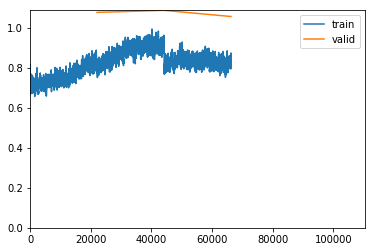

KeyboardInterrupt: 

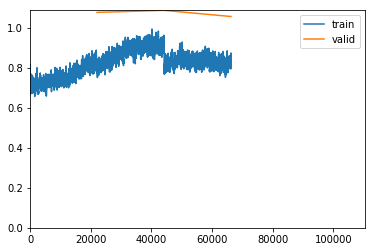

In [30]:
learn.fit_one_cycle(5, max_lr=lrs)

### observations: 

- when training the full resnet body there is a strong decrease in the CrossEntropy() loss function at the start of each epoch
  - this could be because the model evaluates 1000+ images for some categories and the loss decrease stabilizes after evaluating the first few
- it does take a lot of time to train on the full dataset, especially for trying different models and high image size

### whats next

- I'm going to train a different model (se-resnet50) and reduce the image count per class to about 50%